In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

from astropy.table import Table as ApTable
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import scarlet

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("scarlet")
dlogger.setLevel(logging.INFO)

50
(1, 50, 50)


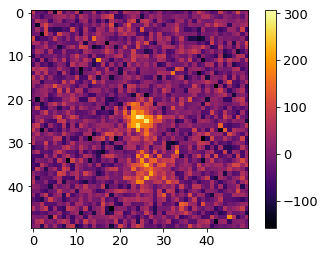

In [84]:
np.random.seed(1)
import scipy.ndimage
#img = np.array([scipy.ndimage.imread("/Users/fred/downloads/test.png")]).astype(np.float64)
img = np.array([scipy.ndimage.imread("/Users/fred/downloads/test2.png")]).astype(np.float64)
_bg_rms = 50
print(_bg_rms)
noise = np.random.normal(scale=_bg_rms,size=img.shape)
print(noise.shape)
img += noise
plt.imshow(img[0])
plt.colorbar()

In [99]:
import imp
imp.reload(scarlet)
imp.reload(scarlet.source)
imp.reload(scarlet.blend)
imp.reload(scarlet.operators)
imp.reload(scarlet.transformations)
imp.reload(scarlet)

<module 'scarlet' from '/Users/fred/lsst/code/scarlet/scarlet/__init__.py'>

In [104]:
# test 1
#coords = [(24.5, 24.5), (36.050461807131782, 27.753741237712376)]
coords = [(24.5, 24.5), (27.753741237712376, 36.050461807131782)]

#test 2
#coords = [(24.5, 24.5), (25.705679379667469, 36.439277081693206)]
#coords = [(24.5, 24.5), (36.439277081693206, 25.705679379667469)]

In [105]:
bg_rms = [_bg_rms for _img in img]
constraints = {"S": None, "m": {'use_nearest': False}, "+":None}

from scarlet.source import init_templates, init_bulge_disk
from functools import partial

init_func = partial(init_bulge_disk)

init_shape = (img.shape[0],)+(15,15)
sources = [scarlet.source.Source((coord[0],coord[1]), init_shape, constraints=constraints, K=2, init_func=init_func) for coord in coords]
blend = scarlet.blend.Blend(sources, img, bg_rms=bg_rms)

SourceInitError: Zero or negative flux at the peak for source at y=28, x=36

In [102]:
#blend.fit(20)
#blend.remove_degenerate_components(1e-5)
#blend.fit(40)
#blend.remove_degenerate_components(1e-5)
blend.fit(200)

INFO:scarlet.blend:resizing source 0 from (9,7) to (19,17) at it 10
INFO:scarlet.blend:max height: 53, width:53
INFO:proxmin:Completed 191 iterations


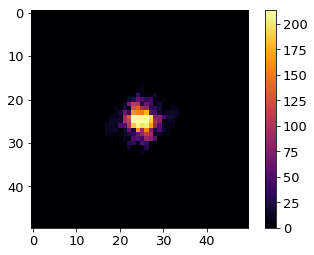

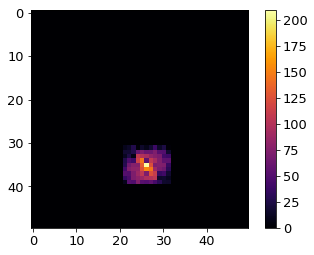

In [103]:
for k in range(len(blend.sources)):
    m = blend.get_model(m=k)
    plt.imshow(m[0])
    plt.colorbar()
    plt.show()

In [47]:
print("Total image size: {0}".format(blend._img[0].size))
total = 0
for n, src in enumerate(blend.sources):
    print("Source {0} size: {1}".format(n, src.shape[0]*src.shape[1]))
    total += src.shape[0]*src.shape[1]
print("Old total size:", blend._img[0].size*len(blend.sources))
print("New total size: {0} or {1}%".format(total, 100*total/blend._img[0].size/len(blend.sources)))

Total image size: 2560
Source 0 size: 162
Source 1 size: 102
Source 2 size: 114
Source 3 size: 174
Source 4 size: 90
Source 5 size: 114
Old total size: 15360
New total size: 756 or 4.921875%


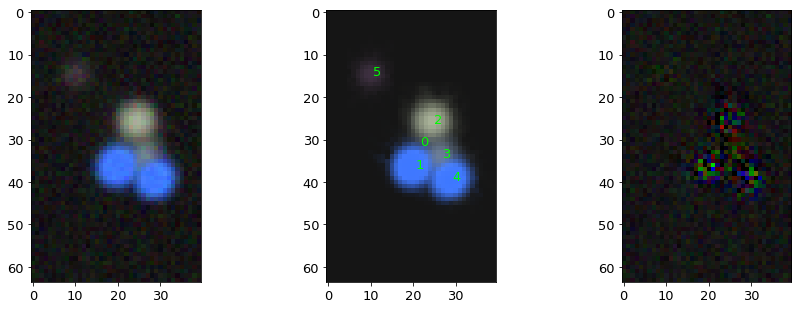

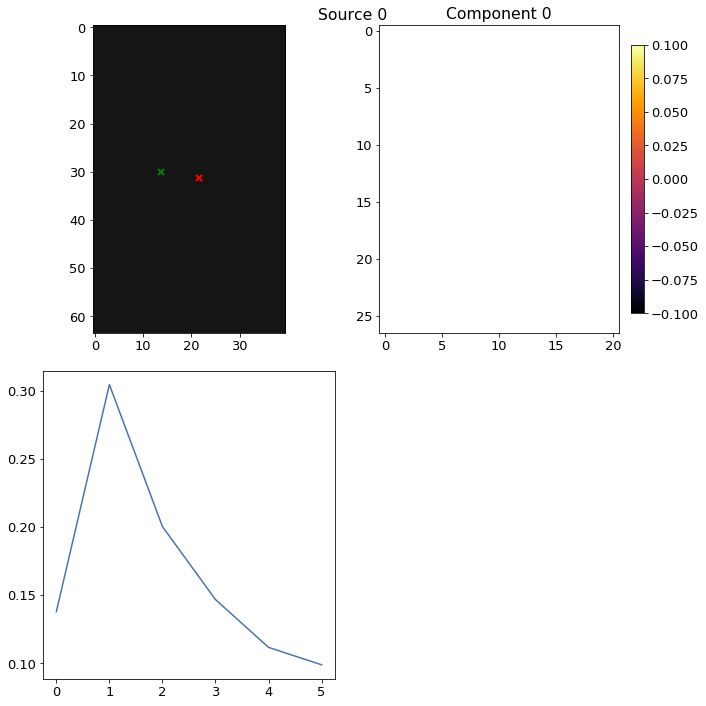

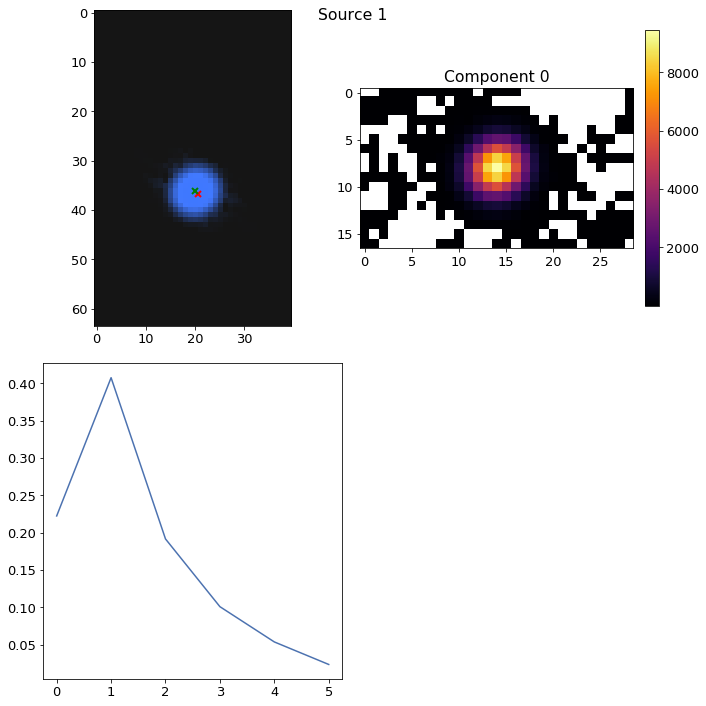

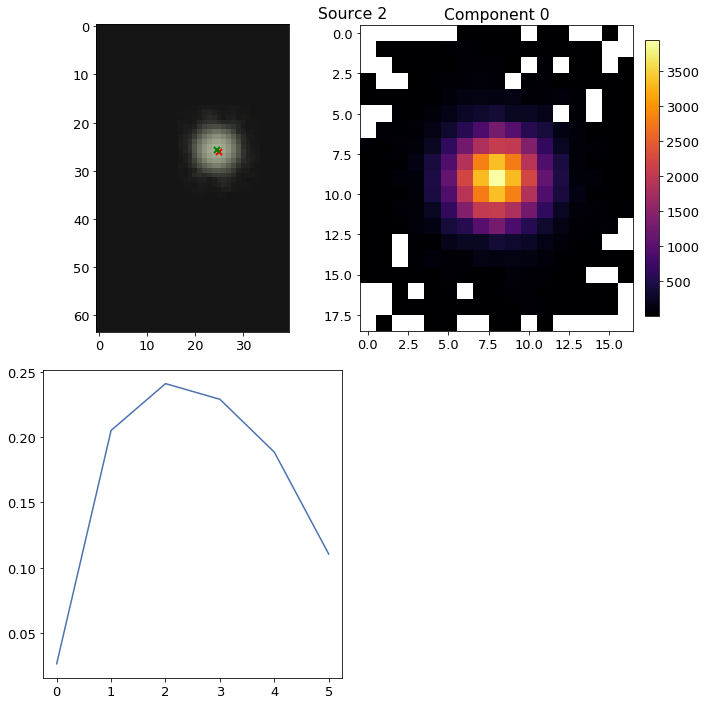

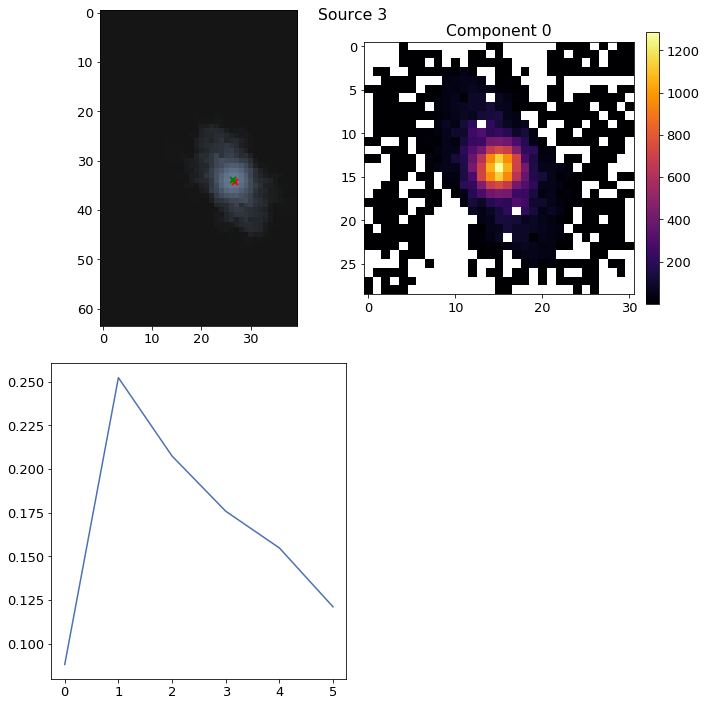

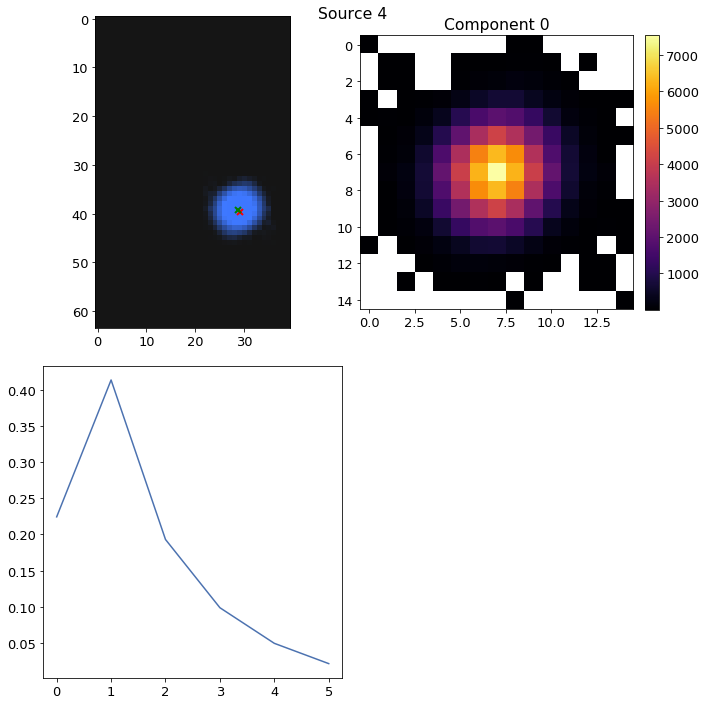

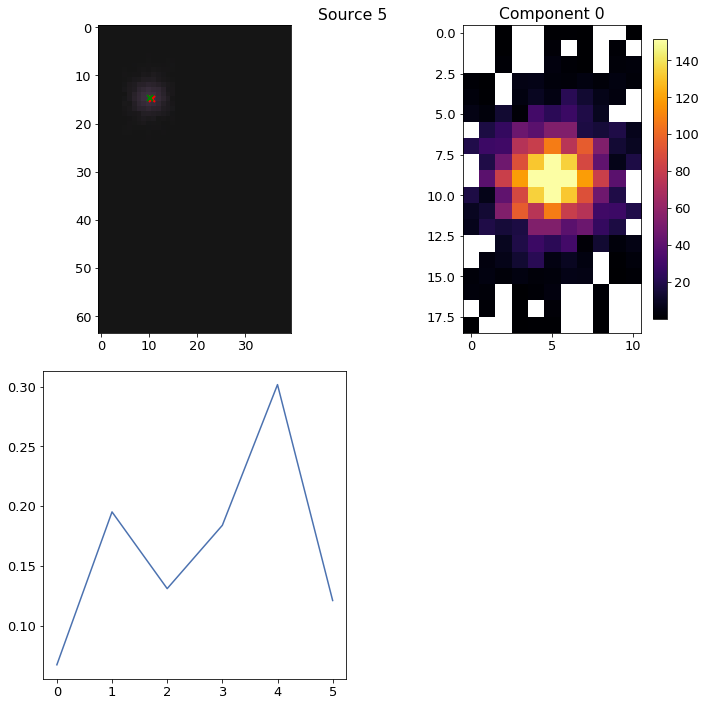

In [36]:
vmin = np.min(img)
vmax = 100

model = blend.get_model()
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
display.plotColorImage(images=img, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, ax=ax1, show=False)
display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax2)
display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax, show=False, ax=ax3)
#display.plotColorImage(images=img-model, filterIndices=[3,2,1], Q=8, show=False, ax=ax3)
for m,coord in enumerate(coords):
    ax2.text(coord["x"], coord["y"], str(m), color="lime")
plt.show()

full_model = np.zeros_like(model)
for m in range(len(coords)):
    model = blend.get_model(m=m)
    full_model += model
    sources = blend.sources[m].K
    rows = np.ceil((sources+2)/2)
    fig = plt.figure(figsize=(10,5*rows))
    ax = [fig.add_subplot(rows,2, n+1) for n in range(sources+2)]
    display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax, ax=ax[0])
    #display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin*0, vmax=vmax/20)
    ax[0].plot(coords["x"][m], coords["y"][m], 'rx', mew=2)
    y,x = blend.sources[m].center
    #ax1.scatter(x,y,s=80,facecolor='none',edgecolor='r')
    ax[0].plot(x, y, 'gx', mew=2)
    src = blend.sources[m]
    for k in range(src.K):
        morph = src.morph[k].reshape(src.Ny,src.Nx)
        im = ax[k+1].imshow(np.ma.array(morph, mask=morph==0))
        ax[k+1].set_title("Component {0}".format(k))
        fig.colorbar(im, ax=ax[k+1],fraction=0.046, pad=0.04)
    for n,sed in enumerate(src.sed):
        ax[-1].plot(sed, label="Component {0}".format(n))
    plt.suptitle("Source {0}".format(m))
    plt.tight_layout()
    plt.show()